In [1]:
import time
import torch
import numpy as np
from numba import jit
import networkx as nx
from matplotlib import pyplot as plt
from label_spreading import *

plt.style.use('dark_background')

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [25]:
from joblib import Parallel, delayed

@jit(nopython=True)
def process_weight_matrix(W):
    W = np.maximum(W, W.T)
    row_sums = W.sum(axis=1)
    W /= row_sums[:, np.newaxis]
    np.fill_diagonal(W, 0)
    return W


@jit(nopython=True)
def generate_weight_matrix(n, sigma=0.01):
    W = np.random.rand(n, n)
    W -= np.mean(W) # center distribution around zero
    W += np.random.normal(0, sigma, (n, n)) # add deviation
    W = np.clip(W, 0.0, 1.0)    # clip values within 0.0-1.0
    W = process_weight_matrix(W)
    return W

# @jit(nopython=True)
# def generate_weight_matrix(n, low, high):
#     W = np.random.uniform(low, high, size=(n, n))
#     W = process_weight_matrix(W)
#     return W


def create_sparse_matrix(n, m, zero_percentage, rng_seed=42):
    np.random.seed(rng_seed)  

    total_elements = n * m
    num_zeros = int(zero_percentage * total_elements)
    num_non_zeros = total_elements - num_zeros

    a = np.zeros(num_zeros, dtype=np.uint8)
    b = np.random.randint(1, 11, num_non_zeros)

    elements = np.concatenate((a, b))
    np.random.shuffle(elements)

    sparse_matrix = np.reshape(elements, (n, m))
    return sparse_matrix


def initialize_population(population_len, n, value_range, n_jobs=-1):
    population = Parallel(n_jobs=n_jobs)(
        delayed(generate_weight_matrix)(n, 0.01) for _ in range(population_len)
    )
    return population


In [26]:
@jit(nopython=True)
def get_test_indices(data, test_size=0.3, rng_seed=42):
    # np.random.seed(rng_seed)
    test_indices_list = []
    
    for row in data:
        nonzero_indices = np.nonzero(row)[0]
        num_indices_to_keep = int(np.ceil(test_size * len(nonzero_indices)))
        selected_indices = np.random.choice(nonzero_indices, size=num_indices_to_keep, replace=False)
        test_indices_list.append(selected_indices)
    
    return test_indices_list


def run_label_spreading(W, original_data, predicted_data, test_indices, device, alpha=0.5, verbose=True):   # change alpha to .8
    adj_matrix_t = torch.tensor(W, dtype=torch.float64, device=device)  # maybe change float64 to 32 for better gpu optimaziation

    for i in range(original_data.shape[0]):
        labels_t = torch.tensor( original_data[i, :].copy() , dtype=torch.long, device=device)
        
        if len(test_indices[i]):
            labels_t[test_indices[i]] = 0
        
        labels_t[labels_t == 0] = -1
            
        label_spreading = LabelSpreading(adj_matrix_t)
        label_spreading.fit(labels_t, alpha=alpha, verbose=verbose)
        label_spreading_output_labels = label_spreading.predict_classes()
        predicted_data[i, :] = label_spreading_output_labels.cpu() if 'cuda' in device.type else label_spreading_output_labels


@jit(nopython=True)
def mean_absolute_error(y_true, y_pred, denom):
    return np.sum(np.abs(y_true - y_pred)) / denom


@jit(nopython=True)
def mean_squared_error(y_true, y_pred, denom):
    return np.sum((y_true - y_pred) ** 2) / denom


def get_fitness(original_data, predicted_data, test_indices):
    e = []

    for i in range(original_data.shape[0]):
        if len(test_indices[i]):
            # casting to np.in8 from unsigned to avoid underflow from negative differences
            y_true = original_data[i, test_indices[i]].astype(np.int8)
            y_pred = predicted_data[i, test_indices[i]].astype(np.int8)
            # mae = mean_absolute_error(y_true, y_pred, len(y_true))
            mse = mean_squared_error(y_true, y_pred, len(y_true))
            e.append(mse)
        else:
            raise Exception('empty test sample')
                
    return -np.sum(e) / len(test_indices)


def evaluate_population(population, original_data, test_indices, device, verbose=True):
    scores = [ [i, None, None] for i in range(len(population)) ] 
    
    for i in range(len(population)):
        predicted_data = np.empty_like(original_data)
        run_label_spreading(population[i], original_data, predicted_data, test_indices, device=device, verbose=verbose)
        scores[i][1] = get_fitness(original_data, predicted_data, test_indices)
        scores[i][2] = predicted_data
        
    return scores

In [27]:
import random

@jit(nopython=True)
def crossover(W1, W2, W1_score, W2_score, alpha=0.5):
    beta = 1 - alpha
    combined_matrix = alpha * W1 + beta * W2 if W1_score > W2_score else alpha * W2 + beta * W1
    return process_weight_matrix(combined_matrix)
    

def elitist_selection(sorted_scores, elite_percentage):
    elite_size = int(len(sorted_scores) * elite_percentage)
    elites_indices = [ sorted_scores[i][0]  for i in range(elite_size) ]
    return elites_indices


def tournament_selection(scores, elite_indices, num_parents):
    parents_indices = elite_indices.copy()
    parents_indices_set = set(parents_indices)
    individuals_indices = set(range(len(scores)))

    while len(parents_indices) < num_parents:
        available_indices = list(individuals_indices - parents_indices_set)
        try:
            tournament_indices = np.random.choice(available_indices, len(available_indices), replace=False)
        except Exception:
            raise f'unable to create tournament of size: {len(available_indices)} from {len(available_indices)} individuals (without replacement)'

        tournament_scores = [ (i, scores[i][1]) for i in tournament_indices ]
        winner_idx = max(tournament_scores, key=lambda x: x[1])[0]

        if winner_idx not in parents_indices:
            parents_indices.append(winner_idx)
            parents_indices_set.add(winner_idx)
    
    return parents_indices 


@jit(nopython=True)
def mutate_matrix(W, mutation_rate, mutation_range):
    mutated_matrix = np.copy(W)
    rows, cols = mutated_matrix.shape
    num_mutations = int(np.ceil(mutation_rate * rows * cols))

    mutation_indices = np.random.randint(0, rows * cols, num_mutations)
    # decomposing the random indices into row and column indices: 
    row_indices = mutation_indices // cols
    col_indices = mutation_indices % cols

    mutation_values = np.random.uniform(mutation_range[0], mutation_range[1], num_mutations)

    for i in range(num_mutations):
        mutated_matrix[row_indices[i], col_indices[i]] += mutation_values[i]    # assign mutated value to corresponding position
        mutated_matrix[row_indices[i], col_indices[i]] = max(0.0, min(1.0, mutated_matrix[row_indices[i], col_indices[i]]))     # clip values withing [0.0, 1.0]

    return process_weight_matrix(mutated_matrix)

In [28]:
import os
import psutil

memory_gb = psutil.virtual_memory().total / 1024**3
print(f'{memory_gb=}')

num_users = 600
print(f'{num_users=}')

num_items = 10
print(f'{num_items=}')

num_cpus = os.cpu_count()
print(f'{num_cpus=}')

partitions = num_cpus - 1
population_len = 35
print(f'{partitions=}, {population_len=}')
value_range = (0.0, 1.0)

memory_gb=62.58143615722656
num_users=600
num_items=10
num_cpus=32
partitions=31, population_len=35


In [29]:
original_data = create_sparse_matrix(num_items, num_users, 0.5)
original_data.shape, np.count_nonzero(original_data) / original_data.size * 100

((10, 600), 50.0)

In [181]:
def run_simulated_annealing(og_individual, og_fitness, data, test_indices, tolorance, max_iterations, mutation_rate, mutation_range, device):
    best_fitness = og_fitness
    new_individual = og_individual.copy()

    for _ in range(max_iterations):
        new_individual = mutate_matrix(new_individual, mutation_rate, mutation_range)
        new_individual_fitness = evaluate_population([new_individual], data, test_indices, device=device, verbose=False)[0][1]
        
        offspring = crossover(og_individual, new_individual, og_fitness, new_individual_fitness, alpha=0.7)
        offspring_fitness = evaluate_population([offspring], data, test_indices, device=device, verbose=False)[0][1]
        
        if offspring_fitness >= tolorance * best_fitness:
            return offspring
        # else:
        #     print(f'{offspring_fitness=}, thes:{tolorance*best_fitness}')
                
    return None

In [182]:
def get_duplicates(l):
    d = dict()
    dups_indices = []

    for idx, v in enumerate(l):
        if v in d:
            dups_indices.append(idx)
        else:
            d[v] = True
    
    return dups_indices

In [183]:
def restart_population(survivors, population_len, n, value_range):
    new_population = survivors.copy()
    new_population.extend(initialize_population(population_len=population_len, n=n, value_range=value_range))
    return new_population

In [261]:
epochs = 350
hist = np.zeros(shape=(epochs, 2), dtype=np.float64)

test_indices = get_test_indices(original_data, test_size=0.4)
max_iterations_values = [5 + (i // 15) for i in range(1, epochs + 1)]   # reduce max_iterations towards the end too much overhead
# tolorance_values = np.linspace(0.95, 1.2, epochs)[::-1]
tolorance_values = np.linspace(1.1, 1.1, epochs)[::-1]
# mutation_rate_values = np.linspace(0.01, 0.00001, epochs)   # increace
mutation_rate_values = np.linspace(0.01, 0.001, epochs)
population = initialize_population(population_len=population_len, n=num_users, value_range=value_range)

In [262]:
og_population = population.copy()

In [263]:
original_data[0, test_indices[0]]

array([10, 10,  8,  2,  8,  1,  2,  3,  4,  5,  5, 10,  6,  4,  4,  1,  6,
        2,  8,  6,  1,  8, 10,  4,  7,  2,  8, 10,  1,  7,  1,  4,  4,  1,
        2,  2,  8,  2,  3, 10,  1, 10,  6,  4,  8, 10,  2,  7,  4,  9, 10,
       10,  8,  2,  2,  9,  3,  5,  5,  5,  1,  6,  9,  5,  8,  6,  4,  2,
        1,  7,  1, 10, 10,  2,  6, 10,  1,  3,  2, 10,  4,  8, 10,  9,  5,
        7,  3,  2,  5,  1,  3,  7,  9,  3, 10,  2,  2,  2,  3,  1, 10,  3,
        4, 10,  5,  6,  8,  6])

In [264]:
import time
elites_indices = []

for i in range(epochs):
    start = time.time()

    avg_value = np.average(population[0])
    l = (epochs - i) / 100 * avg_value
    mutation_range = ( -avg_value -l, avg_value + l )
    mutation_rate = mutation_rate_values[i]
    tolorance = tolorance_values[i]
    max_iterations = max_iterations_values[i]

    scores = evaluate_population(population, original_data, test_indices, device=device, verbose=False)

    if i < epochs // 4:
        dups_indices = get_duplicates([ score[1] for score in scores ])
        while len(dups_indices):
            for idx in dups_indices:
                population[idx] = mutate_matrix(population[idx], mutation_rate, mutation_range)
                scores = evaluate_population(population, original_data, test_indices, device=device, verbose=False)
                dups_indices = get_duplicates([ score[1] for score in scores ])

    valid_scores = [x for x in scores if x[1] != np.finfo(float).max]    
    average_fitness = sum(x[1] for x in valid_scores) / len(valid_scores)
    valid_scores = sorted(valid_scores, key=lambda x:x[1], reverse=True)

    best_fitness = valid_scores[0][1]
    print(f'{i}: {average_fitness=}, {best_fitness=}', end=' ')

    hist[i][0] = average_fitness
    hist[i][1] = best_fitness
    
    elites_indices = elitist_selection(valid_scores, 0.4)
    parents_indices = tournament_selection(valid_scores, elites_indices, population_len // 2)
    random.shuffle(parents_indices)

    parent_pairs = [(parents_indices[j], parents_indices[j + 1]) for j in range(0, len(parents_indices) - 1, 2)]   

    alpha = 0.7
    new_population = [
            crossover(
                population[pair[0]], 
                population[pair[1]],
                scores[pair[0]][1], 
                scores[pair[1]][1], 
                alpha=alpha
            ) for pair in parent_pairs 
        ]

    diff = population_len - len(new_population) - len(parents_indices)
    
    if diff > 0:        
        random.shuffle(parents_indices)
        parent_pairs = [(parents_indices[j], parents_indices[j + 1]) for j in range(0, len(parents_indices) - 1, 2)]   
        cnt = 0

        for j in range(diff):
            idx, fitness = valid_scores[j][0], valid_scores[j][1]
            new_individual = run_simulated_annealing(population[idx], fitness, original_data, test_indices, tolorance, max_iterations, mutation_rate, mutation_range, device=device) 
            
            if new_individual is not None:
                new_population.append(new_individual)
                cnt += 1
            else:
                new_population.append(generate_weight_matrix(num_users, 0.01))
        print(f'changed: {cnt}/{diff}', end=' ')

    new_population.extend([ population[j] for j in parents_indices ])
    population = new_population.copy()

    end = time.time()
    print(f'elapsed time: {end - start}')
    # print(f'{len(parents_indices)=}, {len(parent_pairs)=}, {len(population)=}')

0: average_fitness=-18.763367826024666, best_fitness=-18.210555677928532 changed: 10/10 elapsed time: 1.4476597309112549
1: average_fitness=-18.53392850175895, best_fitness=-18.045696861834024 changed: 10/10 elapsed time: 1.3090848922729492
2: average_fitness=-18.418723575279298, best_fitness=-18.045696861834024 changed: 10/10 elapsed time: 1.2788505554199219
3: average_fitness=-18.361092279415036, best_fitness=-17.851996748233272 changed: 10/10 elapsed time: 1.3106322288513184
4: average_fitness=-18.227425025395288, best_fitness=-17.851996748233272 changed: 10/10 elapsed time: 1.2869725227355957
5: average_fitness=-18.07254635032557, best_fitness=-17.777627074902306 changed: 10/10 elapsed time: 1.2850587368011475
6: average_fitness=-18.025977905728972, best_fitness=-17.506834922668226 changed: 10/10 elapsed time: 1.2672579288482666
7: average_fitness=-17.971432870745282, best_fitness=-17.451711961843934 changed: 10/10 elapsed time: 1.2673487663269043
8: average_fitness=-17.88120057123

In [265]:
best_predictions = sorted(valid_scores, key=lambda x:x[1], reverse=True)[0][2]  # getting the best individual's predictions
best_predictions

array([[ 8,  5,  8, ...,  5,  3,  3],
       [ 8,  6,  6, ...,  7,  8,  7],
       [ 1,  9,  9, ...,  7,  3,  9],
       ...,
       [10,  8, 10, ..., 10,  6,  5],
       [ 5,  7,  5, ...,  7,  1,  6],
       [10, 10, 10, ..., 10,  4,  3]])

In [266]:
def visualize_matrix(matrix):
    plt.imshow(np.log1p(matrix), cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()

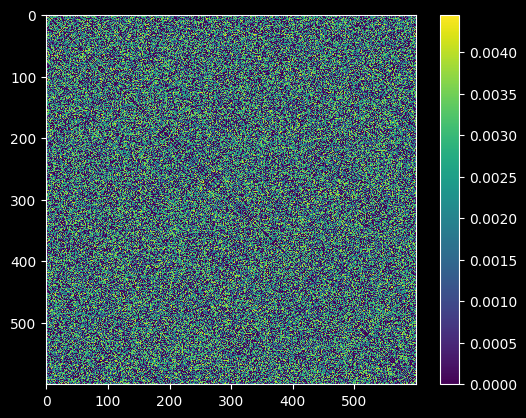

In [267]:
visualize_matrix(og_population[0])

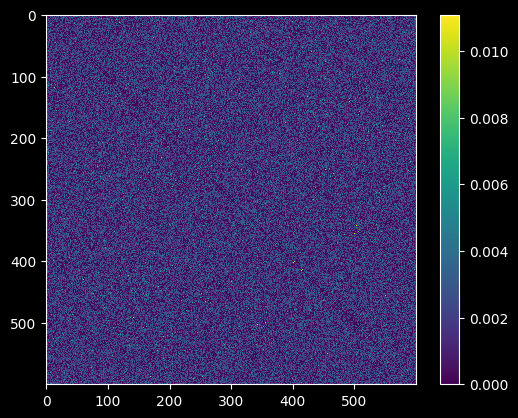

In [268]:
W = population[0].copy()
visualize_matrix(W)

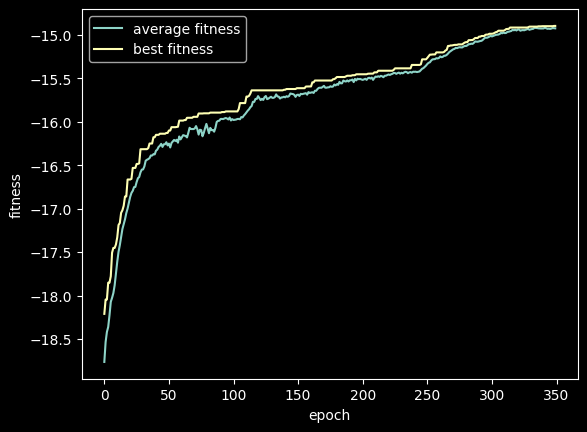

In [270]:
plt.plot(range(epochs), hist[:epochs, :epochs])
plt.legend(['average fitness', 'best fitness'])
plt.savefig('results/gen_algo_results_3')
plt.ylabel('fitness')
plt.xlabel('epoch')
plt.show()

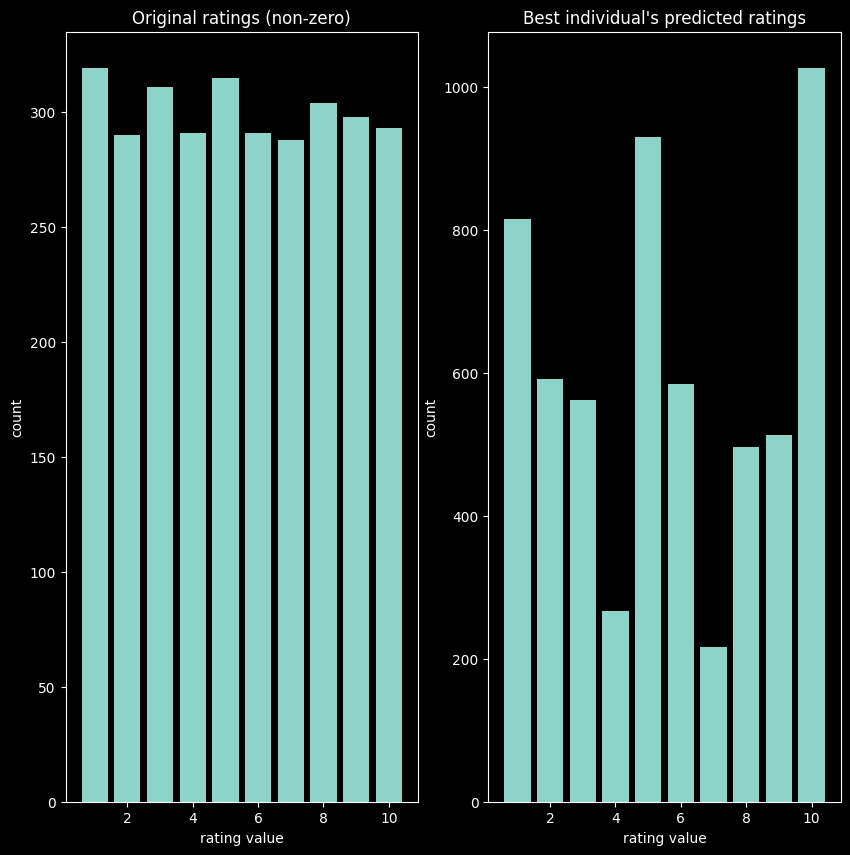

In [271]:
og_ratings_flat = original_data[original_data != 0].flatten()   # flattening the original ratings (non zero values only)
og_ratings_values, og_preds_counts = np.unique(og_ratings_flat, return_counts=True)

best_predictions_flat = best_predictions.flatten()
best_predictions_values, best_predictions_counts = np.unique(best_predictions_flat, return_counts=True)

_, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].bar(og_ratings_values, og_preds_counts)

ax[0].set_xlabel('rating value')
ax[0].set_ylabel('count')
ax[0].set_title('Original ratings (non-zero)')

ax[1].bar(best_predictions_values, best_predictions_counts)

ax[1].set_xlabel('rating value')
ax[1].set_ylabel('count')
ax[1].set_title("Best individual's predicted ratings")

plt.show()

In [272]:
np.count_nonzero(og_population[0]) / og_population[0].size * 100

74.79944444444445

In [273]:
np.count_nonzero(W) / W.size * 100

99.48166666666667

In [274]:
min_value = np.min(W)
max_value = np.max(W)
avg_value = np.average(W)

f'{min_value=}, {max_value=}, {avg_value=}'

'min_value=0.0, max_value=0.011155041744413927, avg_value=0.0016666666666666663'

In [275]:
num_items

10

In [276]:
thres = avg_value + 0.1 * avg_value
thres

0.001833333333333333

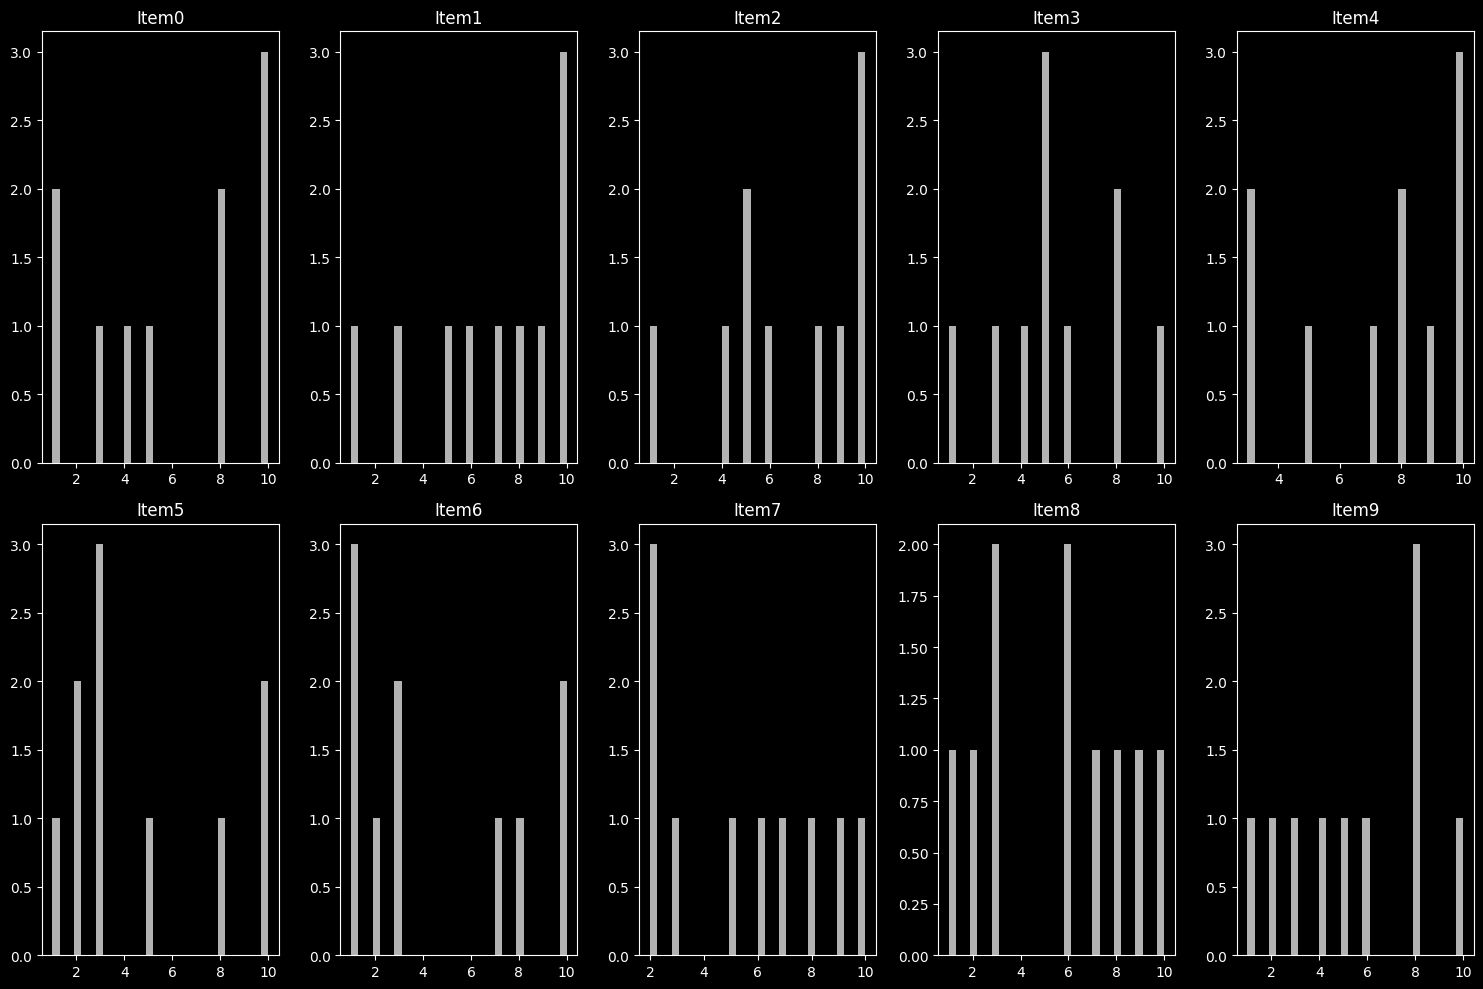

In [277]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))

for i in range(num_items):
    ax = axes[i // 5, i % 5]
    ax.hist(best_predictions[:, i], bins=30, color='white', alpha=0.7)
    ax.set_title(f'Item{i}')

plt.savefig('results/ratings_per_movie_predictions')
plt.tight_layout()
plt.show()

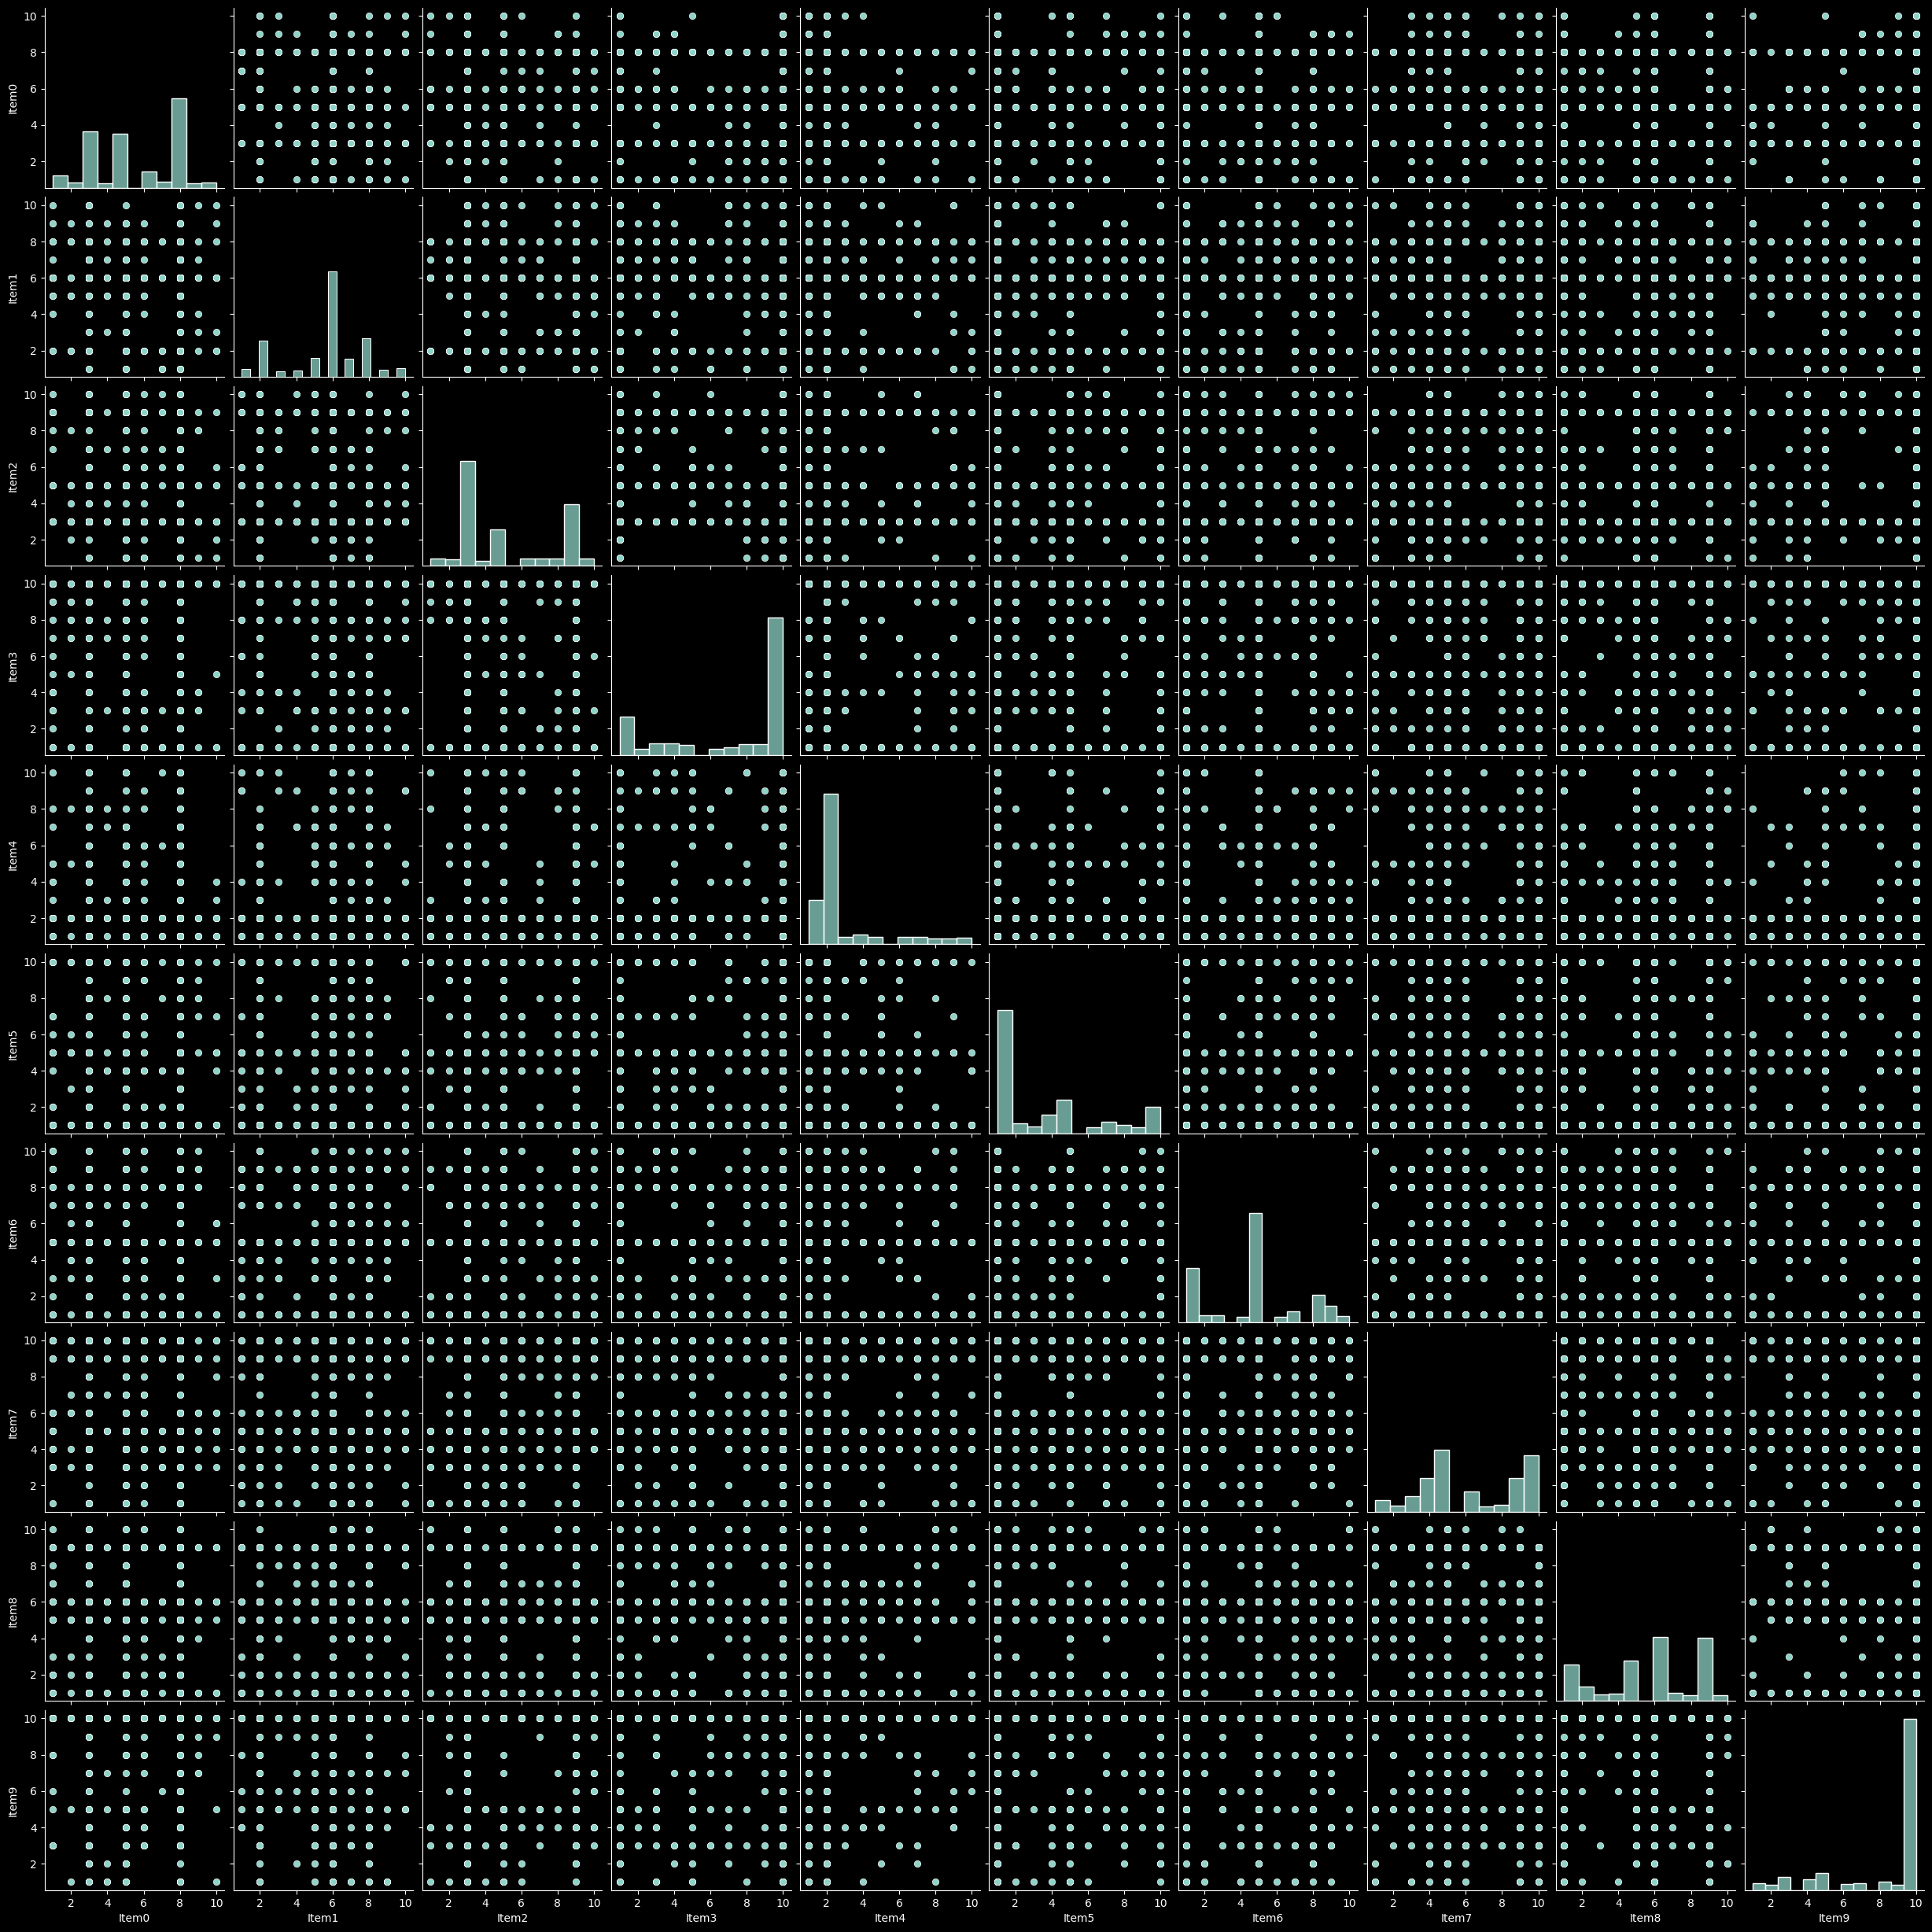

In [278]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(best_predictions.T, columns=[f'Item{i}' for i in range(num_items)])

sns.pairplot(df)
plt.savefig('results/movies_corr')
plt.show()

In [279]:
best_predictions_flat = best_predictions.flatten()
best_predictions_flat.shape

(6000,)

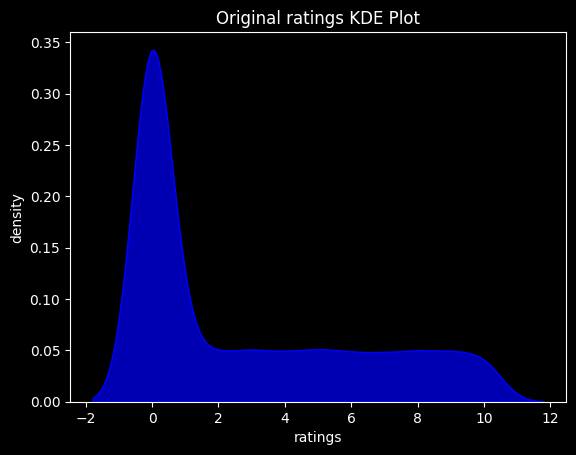

In [282]:
sns.kdeplot(original_data.flatten(), fill=True, color='blue', alpha=0.7)
plt.title('Original ratings KDE Plot')
plt.xlabel('ratings')
plt.ylabel('density')
plt.savefig('results/og_data_kde')
plt.show()

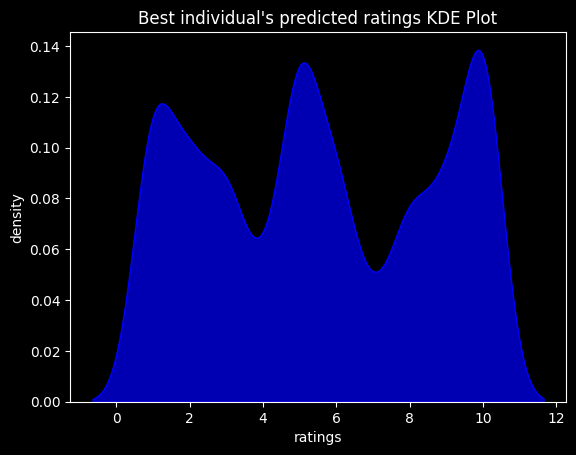

In [283]:
sns.kdeplot(best_predictions_flat, fill=True, color='blue', alpha=0.7)
plt.title("Best individual's predicted ratings KDE Plot")
plt.xlabel('ratings')
plt.ylabel('density')
plt.savefig('results/best_preds_kde')
plt.show()

In [1]:
sample_size = 100

adj_matrix = W[:sample_size, :sample_size]
mask = adj_matrix <= thres
adj_matrix[mask] = 0
adj_matrix[~mask] = 1
np.fill_diagonal(adj_matrix, 0)
print(adj_matrix)
G_sub = nx.from_numpy_array(adj_matrix)

fig, axes = plt.subplots(2, 5, figsize=(30, 20))

graph_pos = []

for i, ax in enumerate(axes.flatten()):
    ax.clear()

    node_colors = best_predictions[i, :sample_size]
    pos = nx.spring_layout(G_sub)
    graph_pos.append(pos)
    
    nodes = nx.draw_networkx_nodes(G_sub, pos=pos, node_color=node_colors, node_size=100, cmap=plt.get_cmap('bwr'), ax=ax)
    edges = nx.draw_networkx_edges(G_sub, pos, edge_color='g', width=0.1, ax=ax)

    unique_ratings = np.unique(best_predictions[i, :sample_size])
    num_colors = len(unique_ratings)
    colormap = plt.cm.get_cmap('bwr', num_colors)

    color_mapping = {rating: colormap(idx) for idx, rating in enumerate(unique_ratings, start=0)}
    node_colors = [color_mapping[rating] for rating in node_colors]

    ax.set_title(f'Users Ratings For Movie {i}')

custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=str(rating), markerfacecolor=color_mapping[rating]) for rating in unique_ratings]
plt.legend(handles=custom_legend, title='Movie Ratings', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('results/user_graph_100')
plt.show()

NameError: name 'W' is not defined